In [54]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [70]:
from aif360.datasets import AdultDataset, BankDataset, CompasDataset, GermanDataset, LawSchoolGPADataset

In [3]:
from BiasGenerator.TemporalBiasGenerator import TemporalBiasGenerator
from BiasGenerator.CauseEffectBiasGenerator import CauseEffectBiasGenerator
from BiasGenerator.SamplingBiasGenerator import SamplingBiasGenerator
from BiasGenerator.MeasurementBiasGenerator import MeasurementBiasGenerator
from BiasGenerator.OmittedVariableBiasGenerator import OmittedVariableBiasGenerator
from BiasGenerator.SimpsonsParadoxGenerator import SimpsonsParadoxGenerator

In [4]:
from Data import Data

# Generic title

In [51]:
def plot(d):
    plt.ylabel("Accuracy")
    plt.xlabel("Bias")
    for i in d:
        plt.plot(d[i]["bias"], d[i]["accuracy"], marker="o", markersize="10")
        plt.annotate(i, (d[i]["bias"], d[i]["accuracy"]), textcoords="offset points", xytext=(0,10), ha='center') 
    plt.show()

In [5]:
RANDOM_STATE = 42
TRAIN_TEST_RATIO = 0.2

# Grades dataset

### Loading data

In [6]:
def load_grades():
    return pd.read_csv("data/famous/CompleteDataAndBiases.csv", index_col="index")

load_grades()

,ParticipantID,name,sex,studytime,freetime,romantic,Walc,goout,Parents_edu,absences,reason,G3,Pass,PredictedGrade,PredictedRank,StereotypeActivation,Predicted_Pass_PassFailStrategy,Predicted_Pass_RankingStrategy
index,,,,,,,,,,,,,,,,,,
132,1,Anna,F,1,2,no,1,2,4,0,course,15,True,17,4,None,True,True
724,1,Michael,M,1,1,no,4,4,4,1,reputation,11,True,10,7,None,True,False
637,1,David,M,1,2,no,4,2,2,0,other,11,True,13,6,None,True,True
884,1,Brian,M,1,1,no,4,4,3,7,home,9,False,10,8,None,True,False
194,1,Jenny,F,2,2,no,1,4,2,0,reputation,14,True,18,3,None,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,107,Anna,F,2,1,no,3,3,2,1,reputation,8,False,10,6,CaseBased,True,False
101,107,Oliver,M,3,3,yes,1,3,4,0,other,17,True,14,3,CaseBased,True,True
518,107,David,M,1,2,yes,1,2,4,7,course,8,False,7,8,CaseBased,False,False


### Preprocessing data

In [7]:
def preproc_grades():
    data = load_grades()

    # remove unwanted features
    data = data.drop(["ParticipantID", "name", "G3", "PredictedRank", "PredictedGrade", "StereotypeActivation"], axis=1)
    # binarize sex
    data["sex"] = data["sex"].apply(lambda x: 1 if x == "F" else 0)
    data["Pass"] = data["Pass"].apply(lambda x: 1 if x else 0)

    # one hot encoding
    one_hot = pd.get_dummies(data[["romantic", "reason"]])
    data = data.drop(["romantic", "reason"], axis=1)
    data = data.join(one_hot)

    fair_data = data.copy()
    fair_data = fair_data.drop(["Predicted_Pass_RankingStrategy", "Predicted_Pass_PassFailStrategy"], axis=1)

    biased_data = data.drop(["Pass",  "Predicted_Pass_PassFailStrategy"], axis=1)
    biased_data = biased_data.rename(columns={"Predicted_Pass_RankingStrategy": "Pass"})
    biased_data["Pass"] = biased_data["Pass"].apply(lambda x: 1 if x else 0)

    return fair_data, biased_data

preproc_grades()

(       sex  studytime  freetime  Walc  goout  Parents_edu  absences  Pass  \
 index                                                                       
 132      1          1         2     1      2            4         0     1   
 724      0          1         1     4      4            4         1     1   
 637      0          1         2     4      2            2         0     1   
 884      0          1         1     4      4            3         7     0   
 194      1          2         2     1      4            2         0     1   
 ...    ...        ...       ...   ...    ...          ...       ...   ...   
 68       1          2         1     3      3            2         1     0   
 101      0          3         3     1      3            4         0     1   
 518      0          1         2     1      2            4         7     0   
 111      1          3         1     1      2            3         0     1   
 550      0          2         3     3      3            4      

In [8]:
def split_grades():
    fair, biased = preproc_grades()
    biased_train, biased_test, fair_train, fair_test = train_test_split(biased, fair, test_size=TRAIN_TEST_RATIO, random_state=RANDOM_STATE)
    
    biased_data_train = Data(biased_train, ["sex"], ["Pass"])
    biased_data_test = Data(biased_test, ["sex"], ["Pass"])

    fair_data_train = Data(fair_train, ["sex"], ["Pass"])
    fair_data_test = Data(fair_test, ["sex"], ["Pass"])
    
    return biased_data_train, biased_data_test, fair_data_train, fair_data_test

### Rebiasing using our method

Testing unfair baseline...
Testing fair baseline...
Testing measurement...
Testing measurement Y...
Testing measurement A...
Testing Omitted (bias)...
Testing Omitted (fair)...
Testing Sampling (men)...
Testing Sampling (women)...
Testing Sampling (forced)...


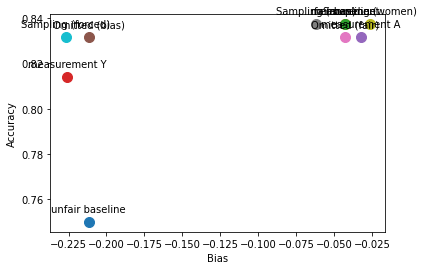

In [53]:
class GradesDatasetTester:
    def __init__(self):
        btr, bte, ftr, fte = split_grades()
        self.biased_train = btr
        self.biased_test = bte
        self.fair_train = ftr
        self.fair_test = fte
    
    def test_all(self, params):
        results = dict()
        results.update(self.basic_unfair())
        results.update(self.basic_fair())
        results.update(self.basic_measurement(params["measurement"], params["a"]))
        results.update(self.y_measurement(params["y"], params["a"]))
        results.update(self.a_measurement(params["a"]))
        results.update(self.omit_bias(params["omit"]))
        results.update(self.omit_fair(params["omit"]))
        results.update(self.sampling_men(params["y"], params["a"]))
        results.update(self.sampling_women(params["y"], params["a"]))
        results.update(self.sampling_forced(params["y"], params["a"]))
        return results
        
    def test_data(self, data, omit=None):
        X_train = data.X()
        y_train = data.y()
        X_test = self.biased_test.X().copy()
        
        if omit is not None:
            X_test = Data(X_test, [], [])
            for i in omit:
                X_test = OmittedVariableBiasGenerator(parameter_to_omit=i).apply(X_test)
                
            X_test = X_test.df()
        model = LogisticRegression(max_iter=200)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)
        return {"preds": preds, "proba": proba}
    
    def evaluate_results(self, results, data):
        preds = results["preds"]
        proba = results["proba"]
        ground_truth = self.fair_test.y()
        
        accuracy = accuracy_score(ground_truth, preds)
        bias = data.metrics().mean_difference()
        
        return {"accuracy": accuracy, "bias": bias}
    
    def basic_unfair(self):
        name = "unfair baseline"
        print(f"Testing {name}...")
        
        train = self.biased_train
        return {name: self.evaluate_results(self.test_data(train), train)}
        
    def basic_fair(self):
        name = "fair baseline"
        print(f"Testing {name}...")
        
        train = self.fair_train
        return {name: self.evaluate_results(self.test_data(train), train)}
     
    def basic_measurement(self, measurement, A):
        name = "measurement"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        for l in measurement:
            train = MeasurementBiasGenerator(parameter=A, parameter_value=1, measurement=l, bias_strength=1).apply(train)
            
        return {name: self.evaluate_results(self.test_data(train), train)}
    
    def y_measurement(self, y, A):
        name = "measurement Y"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        # add new direct bias for females
        train = MeasurementBiasGenerator(parameter=A, parameter_value=1, 
                                         measurement=y, bias_strength=0.08,
                                         weight = {"invalid_ratio": 0,
                                                   "measurement_error": [1, 0]}).apply(train)
        # add new direct bias for males
        train = MeasurementBiasGenerator(parameter=A, parameter_value=0, 
                                         measurement=y, bias_strength=0.315,
                                         weight = {"invalid_ratio": 0,
                                                   "measurement_error": [1, 0]}).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train), train)}
    
    def a_measurement(self, A):
        name = "measurement A"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        train = MeasurementBiasGenerator(parameter=A, parameter_value=1, 
                                         measurement=A, bias_strength=0.3,
                                         weight = {"invalid_ratio": 0,
                                                   "measurement_error": [0.5, 0.5]}).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train), train)}
    
    def omit_bias(self, omit):
        name = "Omitted (bias)"
        print(f"Testing {name}...")
        train = self.biased_train.copy() 
        
        for i in omit:
            train = OmittedVariableBiasGenerator(parameter_to_omit=i).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train, omit=omit), train)}
     
    def omit_fair(self, omit):
        name = "Omitted (fair)"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        for i in omit:
            train = OmittedVariableBiasGenerator(parameter_to_omit=i).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train, omit=omit), train)}
    
    def sampling_men(self, Y, A):
        name = "Sampling (men)"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        train = SamplingBiasGenerator(parameter=A, parameter_value=0, weight={Y: {0:0.5, 1:1}}, bias_strength=0.3).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train), train)}
    
    def sampling_women(self, Y, A):
        name = "Sampling (women)"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        train = SamplingBiasGenerator(parameter=A, parameter_value=1, weight={Y: {0:0.5, 1:1}}, bias_strength=0.3).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train), train)}
    
    def sampling_forced(self, Y, A):
        name = "Sampling (forced)"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        train = SamplingBiasGenerator(parameter=A, parameter_value=0, weight={Y: {0:0, 1:1}}, bias_strength=2/3).apply(train)
        train = SamplingBiasGenerator(parameter=A, parameter_value=1, weight={Y: {0:0, 1:1}}, bias_strength=1/4).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train), train)}
        
grades = GradesDatasetTester()
params = {"measurement": ["studytime", "freetime", "Walc", "goout", "Parents_edu", "absences"],
         "a": "sex",
         "y": "Pass",
         "omit": ["studytime", "freetime", "Parents_edu", "absences", "Walc", "goout", "romantic_no", "romantic_yes", "reason_course", "reason_home", "reason_reputation", "reason_other"]}

plot(grades.test_all(params))

# Synthetic dataset

In [64]:
def synth(num):
    with open(f"data/synthetic/{num}_x.p", "rb") as f:
        data = pickle.load(f)
    
    train, test = data.split(0.2)
    
    grades = GradesDatasetTester()
    grades.biased_train = train
    grades.fair_train = train
    grades.biased_test = test
    grades.fair_test = test
    
    params = {"measurement": [f"X{i}" for i in range(num)],
         "a": "A",
         "y": "Y",
         "omit": [[f"X{i}" for i in range(num)]]}
    
    plot(grades.test_all(params))

### size = 5

Testing unfair baseline...
Testing fair baseline...
Testing measurement...
Testing measurement Y...
Testing measurement A...
Testing Omitted (bias)...
Testing Omitted (fair)...
Testing Sampling (men)...
Testing Sampling (women)...
Testing Sampling (forced)...


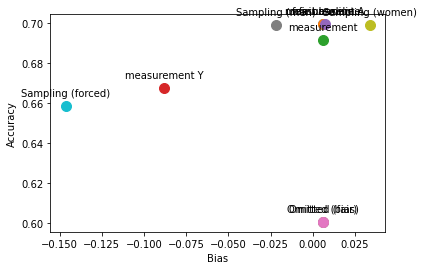

In [65]:
synth(5)

### size = 10

Testing unfair baseline...
Testing fair baseline...
Testing measurement...
Testing measurement Y...
Testing measurement A...
Testing Omitted (bias)...
Testing Omitted (fair)...
Testing Sampling (men)...
Testing Sampling (women)...
Testing Sampling (forced)...


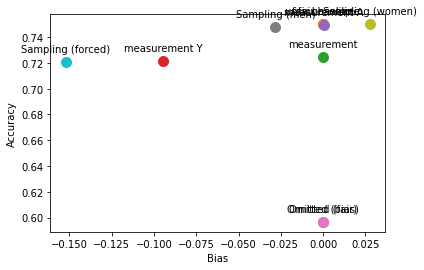

In [66]:
synth(10)

### size = 20

Testing unfair baseline...
Testing fair baseline...
Testing measurement...
Testing measurement Y...
Testing measurement A...
Testing Omitted (bias)...
Testing Omitted (fair)...
Testing Sampling (men)...
Testing Sampling (women)...
Testing Sampling (forced)...


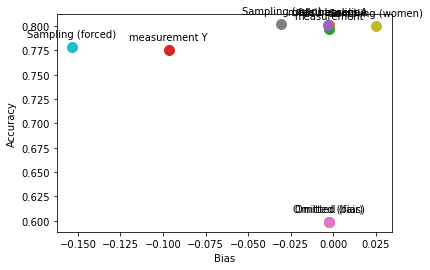

In [67]:
synth(20)

### size = 50

Testing unfair baseline...
Testing fair baseline...
Testing measurement...
Testing measurement Y...
Testing measurement A...
Testing Omitted (bias)...
Testing Omitted (fair)...
Testing Sampling (men)...
Testing Sampling (women)...
Testing Sampling (forced)...


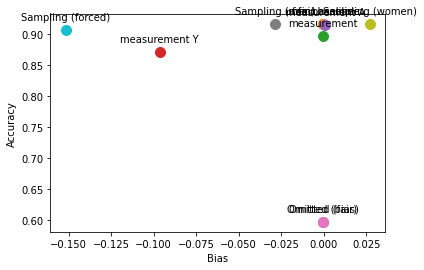

In [68]:
synth(50)

# German Dataset

In [79]:
GermanDataset().convert_to_dataframe()[0]
# age (>=25) sensitive
# sex
# Foreign worker



,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,sex,status=A11,status=A12,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
996,30.0,3857.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
997,12.0,804.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
998,45.0,1845.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0
